In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_ta as ta
import seaborn as sns
import xgboost as xgb
import yfinance as yf
#
import calendar
#
from backtesting import Backtest, Strategy
from sklearn.metrics import accuracy_score, auc, classification_report, cohen_kappa_score, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split

In [25]:
# Download S&P 500 data from the earliest available date up to the current date
sp500_data = yf.download('^GSPC')
sp500_data.index = pd.to_datetime(sp500_data.index)
# Add a new column 'Year' containing the year values
sp500_data['Year'] = sp500_data.index.year
sp500_data['Month'] = sp500_data.index.month
sp500_data['Day'] = sp500_data.index.day
sp500_data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Year,Month,Day
Date,,,,,,,,,
1927-12-30,17.660000,17.660000,17.660000,17.660000,17.660000,0,1927,12,30
1928-01-03,17.760000,17.760000,17.760000,17.760000,17.760000,0,1928,1,3
1928-01-04,17.719999,17.719999,17.719999,17.719999,17.719999,0,1928,1,4
1928-01-05,17.549999,17.549999,17.549999,17.549999,17.549999,0,1928,1,5
1928-01-06,17.660000,17.660000,17.660000,17.660000,17.660000,0,1928,1,6
...,...,...,...,...,...,...,...,...,...
2023-10-09,4289.020020,4341.729980,4283.790039,4335.660156,4335.660156,3174630000,2023,10,9
2023-10-10,4339.750000,4385.459961,4339.640137,4358.240234,4358.240234,3520240000,2023,10,10
2023-10-11,4366.589844,4378.640137,4345.339844,4376.950195,4376.950195,3601660000,2023,10,11


In [26]:
months = [calendar.month_abbr[i] for i in range(1, 13)]
months

['Jan',
 'Feb',
 'Mar',
 'Apr',
 'May',
 'Jun',
 'Jul',
 'Aug',
 'Sep',
 'Oct',
 'Nov',
 'Dec']

In [27]:
# Calculate daily returns
length = 7
sp500_data['Daily_Return'] = sp500_data['Adj Close'].pct_change().shift(-1) * 100
sp500_data['Return0'] = sp500_data['Adj Close'].pct_change() * 100
sp500_data['ATR'] = ta.atr(sp500_data['High'], sp500_data['Low'], sp500_data['Adj Close'], length=length)
sp500_data['RSI'] = ta.rsi(sp500_data['Adj Close'], length=length)

sp500_data

,Open,High,Low,Close,Adj Close,Volume,Year,Month,Day,Daily_Return,Return0,ATR,RSI
Date,,,,,,,,,,,,,
1927-12-30,17.660000,17.660000,17.660000,17.660000,17.660000,0,1927,12,30,0.566254,NaN,NaN,NaN
1928-01-03,17.760000,17.760000,17.760000,17.760000,17.760000,0,1928,1,3,-0.225230,0.566254,NaN,NaN
1928-01-04,17.719999,17.719999,17.719999,17.719999,17.719999,0,1928,1,4,-0.959368,-0.225230,NaN,NaN
1928-01-05,17.549999,17.549999,17.549999,17.549999,17.549999,0,1928,1,5,0.626784,-0.959368,NaN,NaN
1928-01-06,17.660000,17.660000,17.660000,17.660000,17.660000,0,1928,1,6,-0.906001,0.626784,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-09,4289.020020,4341.729980,4283.790039,4335.660156,4335.660156,3174630000,2023,10,9,0.520799,0.630385,57.906603,56.737472
2023-10-10,4339.750000,4385.459961,4339.640137,4358.240234,4358.240234,3520240000,2023,10,10,0.429301,0.520799,56.748489,61.822805
2023-10-11,4366.589844,4378.640137,4345.339844,4376.950195,4376.950195,3601660000,2023,10,11,-0.624643,0.429301,53.398747,65.718311


In [28]:
# Create a DataFrame with average daily returns by month and day
average_returns_by_date = sp500_data.groupby([sp500_data.index.month, sp500_data.index.day])['Daily_Return'].mean()

# Reshape the data to create the calendar table
calendar_table = average_returns_by_date.unstack(level=0)

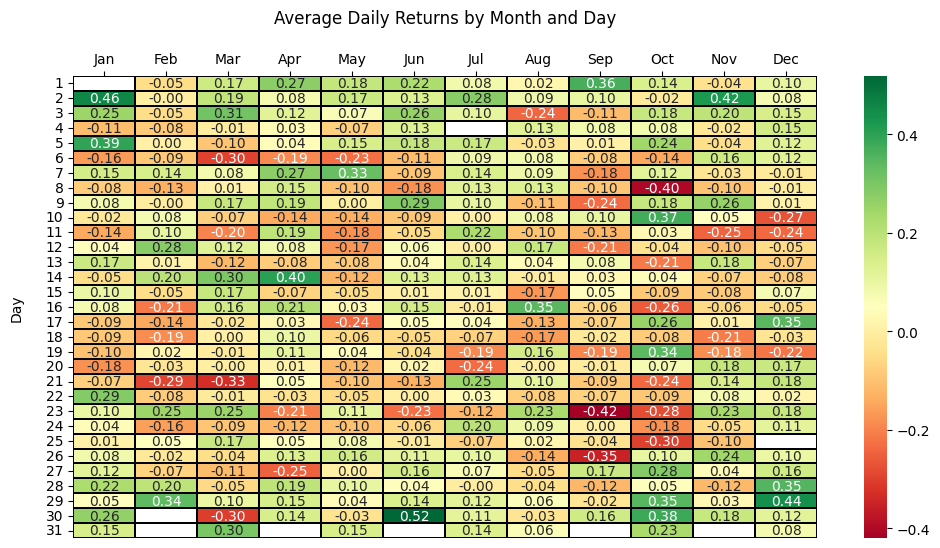

In [29]:
# Create a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(calendar_table, cmap='RdYlGn', annot=True, fmt=".2f", cbar=True, linewidths=0.1, linecolor='black')
plt.title('Average Daily Returns by Month and Day\n')
plt.xlabel('')
plt.ylabel('Day\n')
plt.yticks(rotation=0)
ax = plt.gca()
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
ax.set_xticklabels(months, ha='center')
plt.show()

In [30]:
# Create a dictionary to store dynamic tables
dynamic_tables = {}
avg_returns_previous_years = {}
# Iterate over years and create dynamic tables
for year in range(sp500_data.index.year.min(), sp500_data.index.year.max() + 1):
    dynamic_table = calendar_table.copy()  # Copy the base table
    # Filter data for the specific year
    year_data = sp500_data[sp500_data.index.year == year].copy()
    prev_year_data = sp500_data[sp500_data.index.year < year].copy()
    prev_year_data['Month'] = prev_year_data.index.month
    prev_year_data['Day'] = prev_year_data.index.day
    # Group data by month and day for the specific year
    year_avg_returns = year_data.groupby([year_data.index.month.rename('Month'), year_data.index.day.rename('Day')])['Daily_Return'].mean()
    # Store the dynamic table in the dictionary
    dynamic_tables[year] = year_avg_returns
    # Calculate average returns based on all previous years
    avg_returns_by_date = prev_year_data.groupby(['Month', 'Day'])['Daily_Return'].mean().reset_index()
    avg_returns_previous_years[year] = avg_returns_by_date

In [31]:
dynamic_tables[2023]

Month  Day
1      3      0.753897
       4     -1.164553
       5      2.284078
       6     -0.076763
       9      0.697823
                ...   
10     9      0.520799
       10     0.429301
       11    -0.624643
       12    -0.501886
       13          NaN
Name: Daily_Return, Length: 197, dtype: float64

In [32]:
avg_returns_previous_years[2023]

,Month,Day,Daily_Return
0,1,2,0.458404
1,1,3,0.242738
2,1,4,-0.092723
3,1,5,0.366417
4,1,6,-0.166179
...,...,...,...
358,12,27,0.162674
359,12,28,0.352714
360,12,29,0.440116
361,12,30,0.115970


In [33]:
# Data Preparation for training an XGBoost model
combined_df = pd.concat(avg_returns_previous_years.values(), keys=avg_returns_previous_years.keys())
combined_df.rename(columns={'Daily_Return':'Hist_Daily_Return'},inplace=True)
combined_df

Month  Day  Hist_Daily_Return
1928 0       12   30           0.566254
1929 0        1    3          -0.225230
     1        1    4          -0.959368
     2        1    5           0.626784
     3        1    6          -0.906001
...         ...  ...                ...
2023 358     12   27           0.162674
     359     12   28           0.352714
     360     12   29           0.440116
     361     12   30           0.115970
     362     12   31           0.076702

[34187 rows x 3 columns]

In [34]:
# Define a threshold for higher returns
threshold = 0.0

# Add target variable (1 for higher returns, 0 for lower returns)
combined_df = combined_df.reset_index(level=0).rename(columns={'level_0':'Year'})
combined_df = combined_df.merge(sp500_data.reset_index(),on=['Year','Month','Day'],how='inner')
combined_df['Target'] = (combined_df['Daily_Return'] > threshold).astype(int)
combined_df

,Year,Month,Day,Hist_Daily_Return,Date,Open,High,Low,Close,Adj Close,Volume,Daily_Return,Return0,ATR,RSI,Target
0,1929,1,3,-0.225230,1929-01-03,24.860001,24.860001,24.860001,24.860001,24.860001,0,-0.040226,0.201536,0.238780,86.726370,0
1,1929,1,4,-0.959368,1929-01-04,24.850000,24.850000,24.850000,24.850000,24.850000,0,-2.414488,-0.040226,0.206098,86.125210,0
2,1929,1,9,-0.742852,1929-01-09,24.540001,24.540001,24.540001,24.540001,24.540001,0,0.162995,1.530827,0.255414,64.458756,1
3,1929,1,10,-0.115144,1929-01-10,24.580000,24.580000,24.580000,24.580000,24.580000,0,-0.162730,0.162995,0.224641,65.362812,0
4,1929,1,11,0.691636,1929-01-11,24.540001,24.540001,24.540001,24.540001,24.540001,0,0.203746,-0.162730,0.198263,63.478992,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,2023,10,9,0.170921,2023-10-09,4289.020020,4341.729980,4283.790039,4335.660156,4335.660156,3174630000,0.520799,0.630385,57.906603,56.737472,1
23695,2023,10,10,0.373291,2023-10-10,4339.750000,4385.459961,4339.640137,4358.240234,4358.240234,3520240000,0.429301,0.520799,56.748489,61.822805,1
23696,2023,10,11,0.037460,2023-10-11,4366.589844,4378.640137,4345.339844,4376.950195,4376.950195,3601660000,-0.624643,0.429301,53.398747,65.718311,0
23697,2023,10,12,-0.026419,2023-10-12,4380.939941,4385.850098,4325.430176,4349.609863,4349.609863,3713140000,-0.501886,-0.624643,54.401772,55.980252,0


In [35]:
features = ['Month', 'Day', 'Return0', 'ATR', 'RSI','Hist_Daily_Return']
X = combined_df[features]
y = combined_df['Target']

# Calculate the index for splitting
train_percentage = 0.8
split_index = int(len(combined_df) * train_percentage)

# Split the data into features (X) and target variable (y)
X_train = combined_df.iloc[:split_index][features]
y_train = combined_df.iloc[:split_index]['Target']

X_test = combined_df.iloc[split_index:][features]
y_test = combined_df.iloc[split_index:]['Target']

In [36]:
# Initialize XGBoost Classifier
xgb_classifier = xgb.XGBClassifier()

# Train the model
xgb_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_classifier.predict(X_test)

c:\Users\manuz\Desktop\Adm\Projects\CalendarDailyReturnsSP500\myvenv\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\manuz\Desktop\Adm\Projects\CalendarDailyReturnsSP500\myvenv\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\manuz\Desktop\Adm\Projects\CalendarDailyReturnsSP500\myvenv\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\manuz\Desktop\Adm\Projects\CalendarDailyReturnsSP500\myvenv\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtyp

In [37]:
# Evaluate the model:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

"""
Accuracy is the ratio of correct predictions to the total number of predictions.
Accuracy = (TP + TN) / (TP + TN + FP + FN)
In your report, the overall accuracy is approximately 0.52, which means the model is correct about 52% of the time.
"""

Accuracy: 0.5154008438818566


'\nAccuracy is the ratio of correct predictions to the total number of predictions.\nAccuracy = (TP + TN) / (TP + TN + FP + FN)\nIn your report, the overall accuracy is approximately 0.87, which means the model is correct about 87% of the time.\n'

In [38]:
report = classification_report(y_test, y_pred)
print(f'Classification Report:\n{report}')

"""
Precision is the ratio of true positives to the sum of true positives and false positives.
Precision = TP / (TP + FP)
In your report, for class 0 (lower returns), the precision is approximately 0.47, and for class 1 (higher returns), precision is approximately 0.55.
This indicates that when the model predicts a certain class, it is correct about 47% of the time for class 0 and 55% of the time for class 1.

Recall is the ratio of true positives to the sum of true positives and false negatives.
Recall = TP / (TP + FN)
In your report, for class 0, the recall is approximately 0.48, and for class 1, the recall is approximately 0.55.
This indicates that the model correctly identifies about 48% of actual class 0 instances and about 55% of actual class 1 instances.

The F1-score is the harmonic mean of precision and recall. It provides a balance between precision and recall.
F1-Score = 2 * (Precision * Recall) / (Precision + Recall)
In your report, for class 0, the F1-score is approximately 0.47, and for class 1, the F1-score is approximately 0.55.

Support is the number of actual occurrences of the class in the test dataset.
In your report, for class 0, there are 2170 instances, and for class 1, there are 2570 instances.

Macro Avg treats all classes equally, while Weighted Avg takes class imbalance into account.
"""

Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.48      0.47      2170
           1       0.55      0.55      0.55      2570

    accuracy                           0.52      4740
   macro avg       0.51      0.51      0.51      4740
weighted avg       0.52      0.52      0.52      4740



'\nPrecision is the ratio of true positives to the sum of true positives and false positives.\nPrecision = TP / (TP + FP)\nIn your report, for class 0 (lower returns), the precision is approximately 0.86, and for class 1 (higher returns), precision is approximately 0.87.\nThis indicates that when the model predicts a certain class, it is correct about 86% of the time for class 0 and 87% of the time for class 1.\n\nRecall is the ratio of true positives to the sum of true positives and false negatives.\nRecall = TP / (TP + FN)\nIn your report, for class 0, the recall is approximately 0.85, and for class 1, the recall is approximately 0.88.\nThis indicates that the model correctly identifies about 85% of actual class 0 instances and about 88% of actual class 1 instances.\n\nThe F1-score is the harmonic mean of precision and recall. It provides a balance between precision and recall.\nF1-Score = 2 * (Precision * Recall) / (Precision + Recall)\nIn your report, for class 0, the F1-score is a

In [39]:
kappa = cohen_kappa_score(y_test, y_pred)
print(f'Cohen\'s Kappa: {kappa}')

"""
Cohen's Kappa ranges from -1 to 1. 
A score of 1 indicates perfect agreement, 0 indicates agreement by chance, and negative values indicate worse than chance agreement.
"""

Cohen's Kappa: 0.02500402973045579


"\nCohen's Kappa ranges from -1 to 1. \nA score of 1 indicates perfect agreement, 0 indicates agreement by chance, and negative values indicate worse than chance agreement.\n"

In [40]:
# Generate random predictions
random_predictions = np.random.choice([0, 1], size=len(y_test))

# Calculate Cohen's Kappa for random chance
kappa_random = cohen_kappa_score(y_test, random_predictions)

print(f'Cohen\'s Kappa for Random Chance: {kappa_random}')

Cohen's Kappa for Random Chance: 0.002406811596779024


In [41]:
# Buy and Hold prediction
buy_and_hold_predictions = np.ones(len(y_test))

# Calculate Cohen's Kappa for buy and hold
kappa_buy_and_hold = cohen_kappa_score(y_test, buy_and_hold_predictions)

print(f'Cohen\'s Kappa for Buy and Hold: {kappa_buy_and_hold}')

Cohen's Kappa for Buy and Hold: 0.0


c:\Users\manuz\Desktop\Adm\Projects\CalendarDailyReturnsSP500\myvenv\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\manuz\Desktop\Adm\Projects\CalendarDailyReturnsSP500\myvenv\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\manuz\Desktop\Adm\Projects\CalendarDailyReturnsSP500\myvenv\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\manuz\Desktop\Adm\Projects\CalendarDailyReturnsSP500\myvenv\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtyp

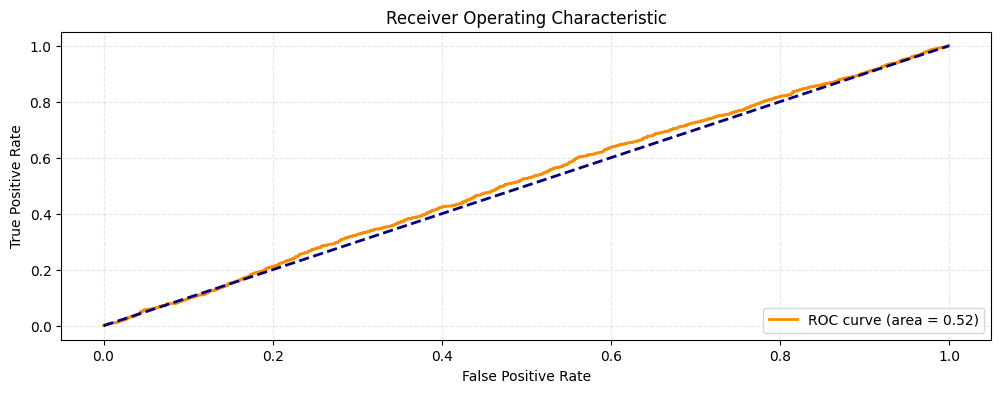

'\nThe term "ROC" in Receiver Operating Characteristic comes from signal detection theory, particularly in the field of radar signal detection.\nThe ROC score (ranging from 0 to 1) measures the area under the ROC curve, also known as AUC (Area Under the Curve). \nAn AUC of 1 represents a perfect model that separates the classes, while an AUC of 0.5 indicates a model that performs no better than random chance.\nAn ROC (Receiver Operating Characteristic) score of 0.95 is an indication of excellent model performance.\n'

In [42]:
# Get predicted probabilities for class 1
y_probs = xgb_classifier.predict_proba(X_test)[:, 1]
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.figure(figsize=(12, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid(True,linestyle='--',alpha=0.3)
plt.show()

"""
The term "ROC" in Receiver Operating Characteristic comes from signal detection theory, particularly in the field of radar signal detection.
The ROC score (ranging from 0 to 1) measures the area under the ROC curve, also known as AUC (Area Under the Curve). 
An AUC of 1 represents a perfect model that separates the classes, while an AUC of 0.5 indicates a model that performs no better than random chance.
An ROC (Receiver Operating Characteristic) score of 0.95 is an indication of excellent model performance.
"""

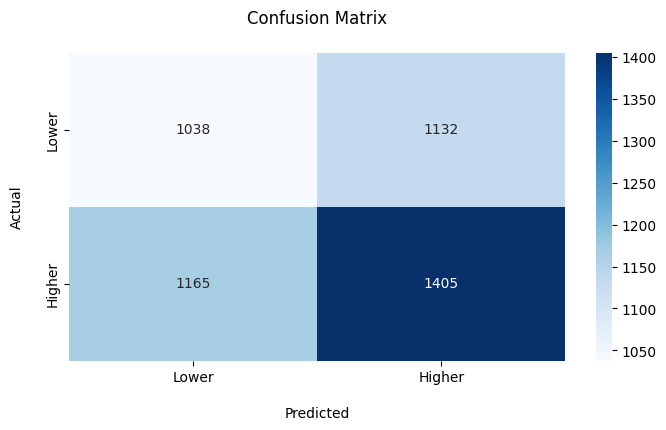

In [43]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Lower', 'Higher'],
            yticklabels=['Lower', 'Higher'])
plt.xlabel('\nPredicted')
plt.ylabel('Actual\n')
plt.title('Confusion Matrix\n')
plt.show()

In [44]:
y_pred_series = pd.Series(y_pred)
y_pred_series.index = y_test.index
y_test = pd.concat([y_test, y_pred_series], axis=1).rename(columns={0:'Prediction'})
y_test

,Target,Prediction
18959,0,0
18960,0,1
18961,1,1
18962,1,1
18963,1,0
...,...,...
23694,1,0
23695,1,0
23696,0,0
23697,0,1


In [45]:
combined_df = combined_df.merge(y_test, left_index=True, right_index=True)
combined_df.set_index('Date',inplace=True)
combined_df

,Year,Month,Day,Hist_Daily_Return,Open,High,Low,Close,Adj Close,Volume,Daily_Return,Return0,ATR,RSI,Target_x,Target_y,Prediction
Date,,,,,,,,,,,,,,,,,
2004-12-15,2004,12,15,0.006157,1203.380005,1206.609985,1199.439941,1205.719971,1205.719971,1695800000,-0.208175,0.194449,9.439341,73.946257,0,0,0
2004-12-16,2004,12,16,0.034759,1205.719971,1207.969971,1198.410034,1203.209961,1203.209961,1793900000,-0.748831,-0.208175,9.456569,68.532302,0,0,1
2004-12-17,2004,12,17,0.403076,1203.209961,1203.209961,1193.489990,1194.199951,1194.199951,2335000000,0.037688,-0.748831,9.494198,52.450216,1,1,1
2004-12-20,2004,12,20,0.142184,1194.199951,1203.430054,1193.359985,1194.650024,1194.650024,1422800000,0.904024,0.037688,9.576465,53.091723,1,1,1
2004-12-21,2004,12,21,0.239830,1194.650024,1205.930054,1194.650024,1205.449951,1205.449951,1483700000,0.341781,0.904024,9.819832,65.951536,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-09,2023,10,9,0.170921,4289.020020,4341.729980,4283.790039,4335.660156,4335.660156,3174630000,0.520799,0.630385,57.906603,56.737472,1,1,0
2023-10-10,2023,10,10,0.373291,4339.750000,4385.459961,4339.640137,4358.240234,4358.240234,3520240000,0.429301,0.520799,56.748489,61.822805,1,1,0
2023-10-11,2023,10,11,0.037460,4366.589844,4378.640137,4345.339844,4376.950195,4376.950195,3601660000,-0.624643,0.429301,53.398747,65.718311,0,0,0


In [46]:
combined_df['positions'] = np.where(combined_df['Prediction']==1,1,
                             np.where(combined_df['Prediction']==0,-1,0))

def _get_feature(data, name):
    return data[name]

# Define the trading strategy you want to test
class Backtesting(Strategy):
    """
    Initialisation Function
    ------------------------------
    This function will initialise an instance of the backtesting class
    """
    def init(self):
        # Get the positions, i.e. actions from agent
        self.positions = self.I(_get_feature, self.data, "positions")
    """
    Next Function
    ------------------------------
    This function will simulate a step, implementing the buy and sell logic based on the supplied actions to the class
    """
    def next(self):
        pos = self.positions[-1]
        # if we are going long
        if pos == 1.:
            # check if not previously long or neutral, if so then close the short position
            if not self.position.is_long:
                if self.position.is_short:
                    self.position.close()
                # now buy
                self.buy()
        # elif we are going short
        elif pos == -1.:
            # check if not previously short or neutral, if so then close the short position
            if not self.position.is_short:
                if self.position.is_long:
                    self.position.close()
                # now sell
                self.sell()
        # else just close the position as we only consider long actions
        elif pos == 0.:
            self.position.close(portion=1)
        # else:
        #     self.position.close(portion=pos)

combined_df['positions'] = combined_df['positions'].shift(-1)
backtest = Backtest(combined_df, Backtesting, cash=10000., commission=0.0001)
results = backtest.run()
print(results)

Start                     2004-12-15 00:00:00
End                       2023-10-13 00:00:00
Duration                   6876 days 00:00:00
Exposure Time [%]                   47.552743
Equity Final [$]                  1719.454269
Equity Peak [$]                       10000.0
Return [%]                         -82.805457
Buy & Hold Return [%]              258.937389
Return (Ann.) [%]                   -8.935338
Volatility (Ann.) [%]               11.055941
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -83.045321
Avg. Drawdown [%]                  -83.045321
Max. Drawdown Duration     6875 days 00:00:00
Avg. Drawdown Duration     6875 days 00:00:00
# Trades                                  939
Win Rate [%]                        44.302449
Best Trade [%]                      10.738682
Worst Trade [%]                    -10.682277
Avg. Trade [%]                    

In [47]:
backtest.plot()

c:\Users\manuz\Desktop\Adm\Projects\CalendarDailyReturnsSP500\myvenv\Lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\manuz\Desktop\Adm\Projects\CalendarDailyReturnsSP500\myvenv\Lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\manuz\Desktop\Adm\Projects\CalendarDailyReturnsSP500\myvenv\Lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
c:\Users\manuz\Desktop\Adm\Projects\CalendarDailyReturnsSP500\myvenv\Lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_scroll' property;

GridPlot(id='p1331', ...)